# NYC Bus Analysis - Data Analysis & Visualization

This analysis is based on the Kaggle dataset 'New York City Bus Data' provided by Michael Stone. The purpose of this exercise is to get a better understanding of bus delays in various areas of New York City.

This notebook is dedicated to data analysis and visualization.

In [540]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gmplot
import sklearn.cross_validation as cv
from sklearn import neighbors as nb
from sklearn import preprocessing
from IPython.display import Image
from geopy.distance import geodesic
import datetime
from datetime import timedelta

%matplotlib inline

In [4]:
dataset=pd.read_pickle('bus_dataset_clean3.pkl')

## Definition of Columns at the end of Preprocessing

Based on information on Kaggle provided by Michael Stone, the columns are defined as follows:

> **RecordedAtTime**: This is the timestamp of the observation from the vehicle and includes both date and time. Each individual vehicle that is in service at the time is observed approximately every 10 minutes in this dataset. <br>
**DirectionRef**: This is either 0 or 1. 0 indicates an outbound route, 1 is inbound. <br>
**PublishedLineName**: The bus route/number e.g. B1 <br>
**OriginName**: Address or bus stop name where bus route starts. <br>
**OriginLat**: Latitude of origin. <br>
**OriginLong**: Longitude of origin. <br>
**DestinationName**: Address or bus stop name where bus route ends. <br>
**DestinationLat**: Latitude of destination. <br>
**DestinationLong**: Longitude of destination.<br>
**VehicleRef**: Each bus has an individual ID number. <br>
**VehicleLocation.Latitude**: Current latitude of bus.<br>
**VehicleLocation.Longitude**: Current longitude of bus. <br>
**NextStopPointName**: Address or bus stop name of next bus stop. <br>
**ArrivalProximityText**: Indication of how far bus is from the bus stop (e.g. approaching, at bus stop, etc). <br>
**DistanceFromStop**:  Distance from stop in feet. <br>
**ExpectedArrivalTime**: The expected actual arrival time at the next stop, as of the time of the observation. This value includes date. <br>
**ScheduledArrivalTime**: This is the time that the bus is SCHEDULED to arrive at the next stop, according to the MTA bus timetable. This value does not include date.<br>
**'ExpectedArrivalHour**: The expected actual arrival time at the next stop, as of the time of the observation. This value does not include date. <br>
**'Delay_Seconds'**: The difference between scheduled arrival time and expected arrival time in seconds. <br>
**'Delay_Minutes'**: The difference between scheduled arrival time and expected arrival time in minutes. <br>
**'RecordedAtTime_Date'**: This is the timestamp of the observation from the vehicle. Only contains date.<br>
**'RecordedAtTime_Time'**: This is the timestamp of the observation from the vehicle. Only contains time.<br>
**'RecordedAtTime_Time_Hour'**: This is the timestamp of the observation from the vehicle. Only contains time in hours.

## Understanding what each row of data means

Each row of data represents a vehicle's status at a given point in time ('RecordedAtTime'). 

Bus route is given by 'PublishedLineName'. It is also commonly known as bus number. One bus route has several buses ('VehicleRef') on it. 'VehicleRef' is specific to each vehicle that takes a bus route. For example, for bus route B1, there are 'VehicleRef' numbers NYCT_4613 ,NYCT_4865, NYCT_4868, NYCT_4870 and so on. Each vehicle can be captured more than once during its journey as measurements are taken approximately every 10 minutes for each vehicle.

This is how the data looks at the end of preprocessing.

In [5]:
dataset.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,ExpectedArrivalHour,Delay_Seconds,Delay_Minutes
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,00:06:14,00:03:59,135,2.0
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,23:58:02,00:03:56,-354,-6.0
2,2017-06-01 00:03:49,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5.0,2017-06-01 00:03:56,00:00:53,00:03:56,-183,-3.0
3,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,00:03:00,00:04:03,-63,-1.0
4,2017-06-01 00:03:22,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11.0,2017-06-01 00:03:56,23:59:38,00:03:56,-258,-4.0


### 1. Overall Delay Statistics

What do we know about delays in June 2017 overall?

1. The average delay is approximately 6 minutes.
2. The longest delay is 301 minutes, which is slightly more than 5 hours.
3. The earliest a bus has arrived is 275 minutes ahead of schedule, which is more than 4.5 hours early.
4. 75% of buses arriving at a particular stop are less than 8 minutes late.
5. 50% of buses are approximately 3 minutes late.
6. 25% of buses are not late.

The longest (5 hours late) and shortest (4.5 hours early) delay values are very much higher than what one would typically expect to see. However, given that there is no additional information available on Kaggle or on the MTA site, it is difficult to understand why such delays are observed. There could be an error in data collection or there could a specific reason for the delay. We are not able to go into further detail regarding these values. 

In [522]:
dataset['Delay_Minutes'].describe()

count    4.972719e+06
mean    -5.731578e+00
std      9.880037e+00
min     -3.010000e+02
25%     -8.000000e+00
50%     -3.000000e+00
75%     -0.000000e+00
max      2.750000e+02
Name: Delay_Minutes, dtype: float64

### 2. On average, how does bus delay vary with time of day?

This dataset contains approximately 5 millions rows. 5 million points cannot be plotted on a graph. Given that this analysis is performed on a personal computer, any more than 50 points take longer than a few minutes to plot. 

Hence, I decided to summarize delay information by time of day across all buses. 

A function 'round_time' was created to truncate time at which the delay information was captured ('RecordedAtTime') to hours. 

The information was grouped by the hour the data was captured, converted into a table with average delay for each hour for the month of June. This was then plotted to obtain Delay (in minutes) against Time (in 24 hours).

In [544]:
#function to round time
def round_time(time):
    return time[0:2]

In [545]:
dataset['RecordedAtTime_Time_Hour'] = dataset['RecordedAtTime_Time'].apply(round_time)

In [547]:
plottinginfo = pd.DataFrame(dataset.groupby(['RecordedAtTime_Time_Hour']).mean())

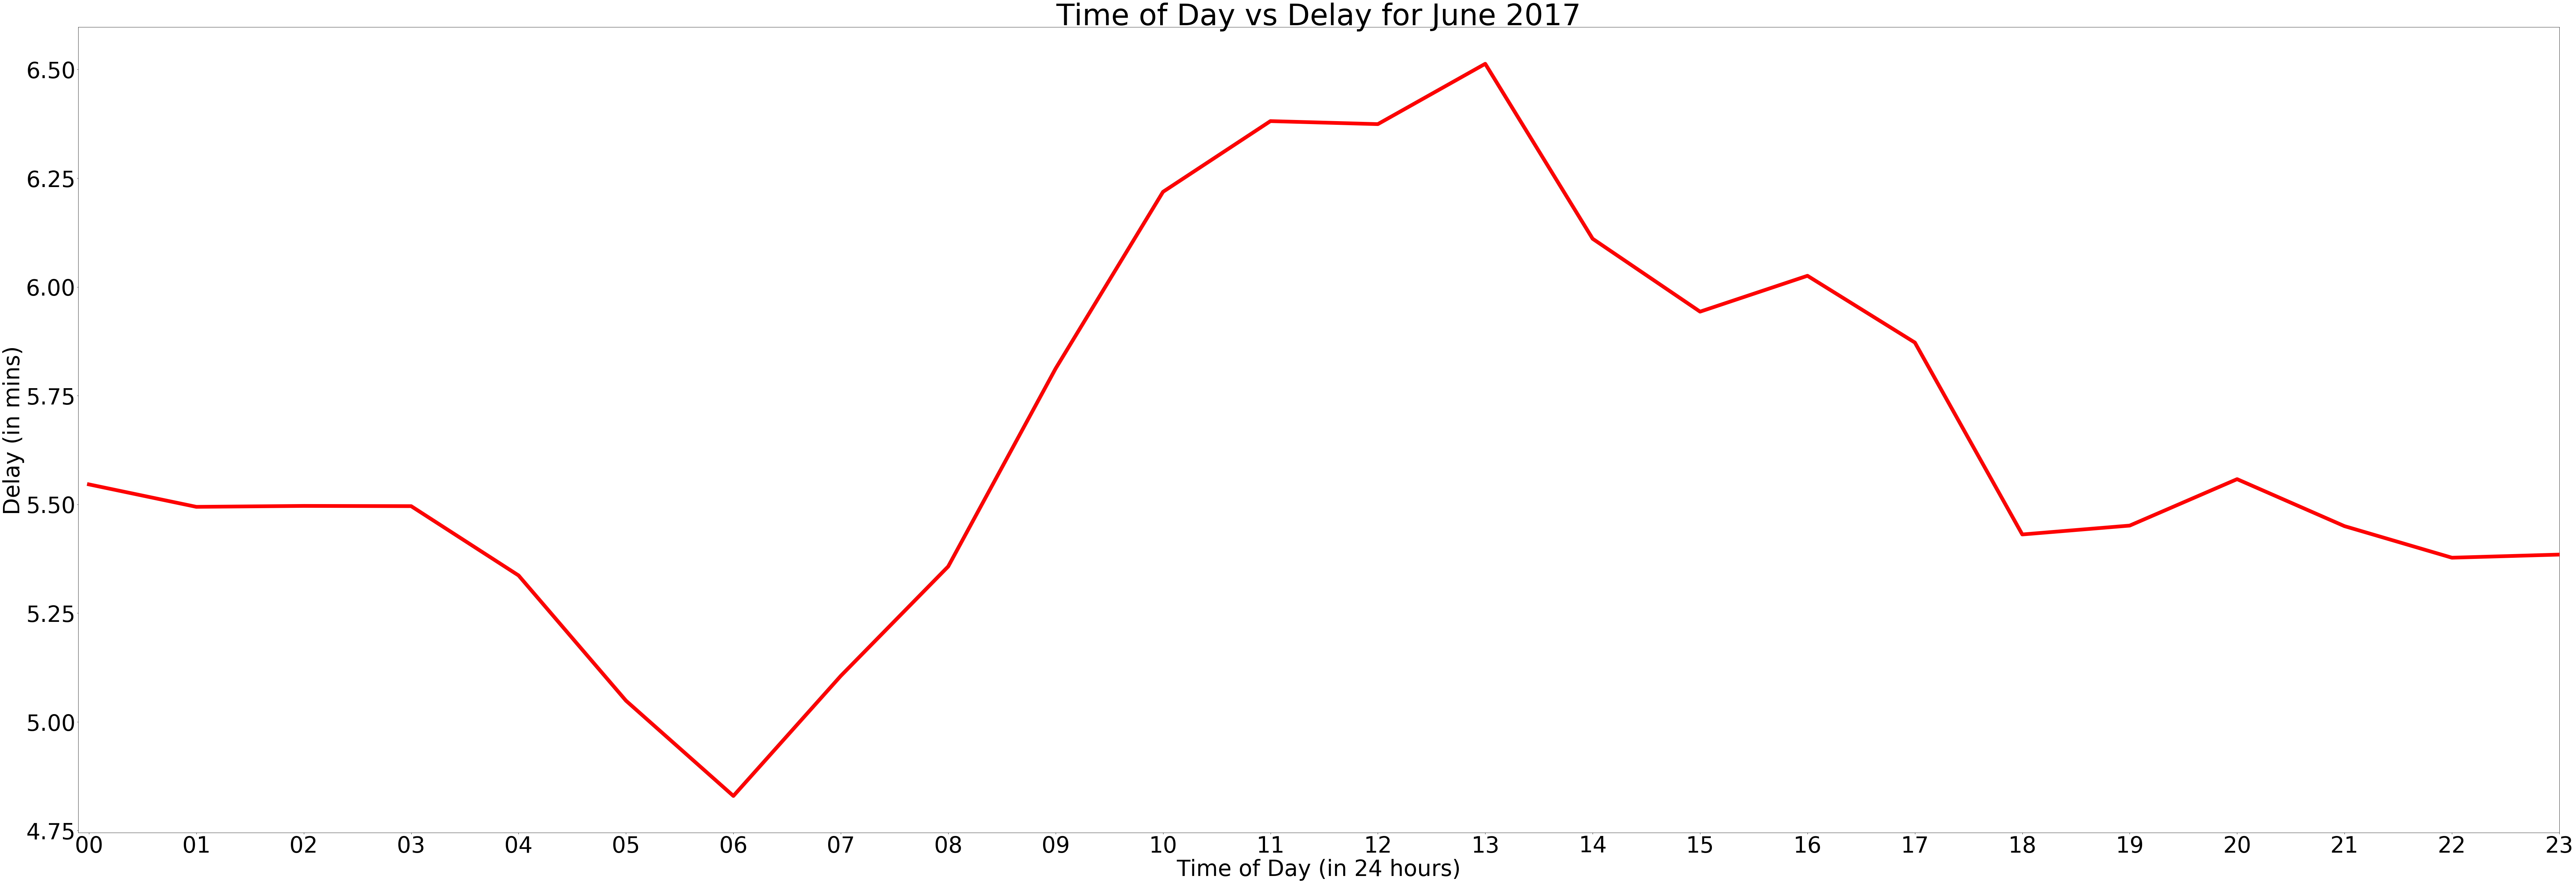

In [549]:
x = plottinginfo.index
y = -plottinginfo['Delay_Minutes']
plt.plot(x,y,'r-',linewidth= 10)
#plt.ylim(ymin=-0.1,ymax=0.1)
plt.xlim(xmin=-0.1,xmax=23)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 120
fig_size[1] = 40
plt.xlabel('Time of Day (in 24 hours)',fontsize = 60)
plt.ylabel('Delay (in mins)', fontsize = 60)
plt.xticks(fontsize = 60)
plt.yticks(fontsize = 60)
plt.title('Time of Day vs Delay for June 2017',fontsize = 80)
plt.show()

1. Across everyday in the month of June, average bus delay was over 4.75 minutes.
2. The highest average bus delay was close to 6.5 minutes, which was observed around 13:00 or 1pm.
3. The lowest average bus delay was 4.8 minutes, which was observed around 6:00 or 6am.
4. Average bus delays were 6 minutes or higher between 09:00 or 9am to 16:00 or 4pm. This pattern of delays aligns with "peak hour" traffic that we see on the road while driving. Given that the values have been averaged over an entire month across all bus routes, it might not strictly align to the "peak hour" traffic pattern observed on one day.

### 3. What are all the points where the buses are located?

I wanted to be able to quickly visualize where on the map the buses were captured to be. 

This pictures tells as that the data only captures buses in Manhattan, Brooklyn and Staten Island. Buses in Queens and the Bronx are not covered in the dataset.

The image belows shows bus location frequency for the month of June. The most number of buses were captured to be in Manhattan, followed by Brooklyn and Staten Island. Buses were seen throughout Manhattan given by the multiple larger red regions. It is interesting to note that buses did not service certain areas, as given by the green regions.

The green rectangular region, marked by a circle, right by Upper East Side does not have buses going through it, as this location corresponds to Central Park, an urban park in Manhattan.

In [516]:
latitudes = dataset['VehicleLocation.Latitude']
longitudes = dataset ['VehicleLocation.Longitude']

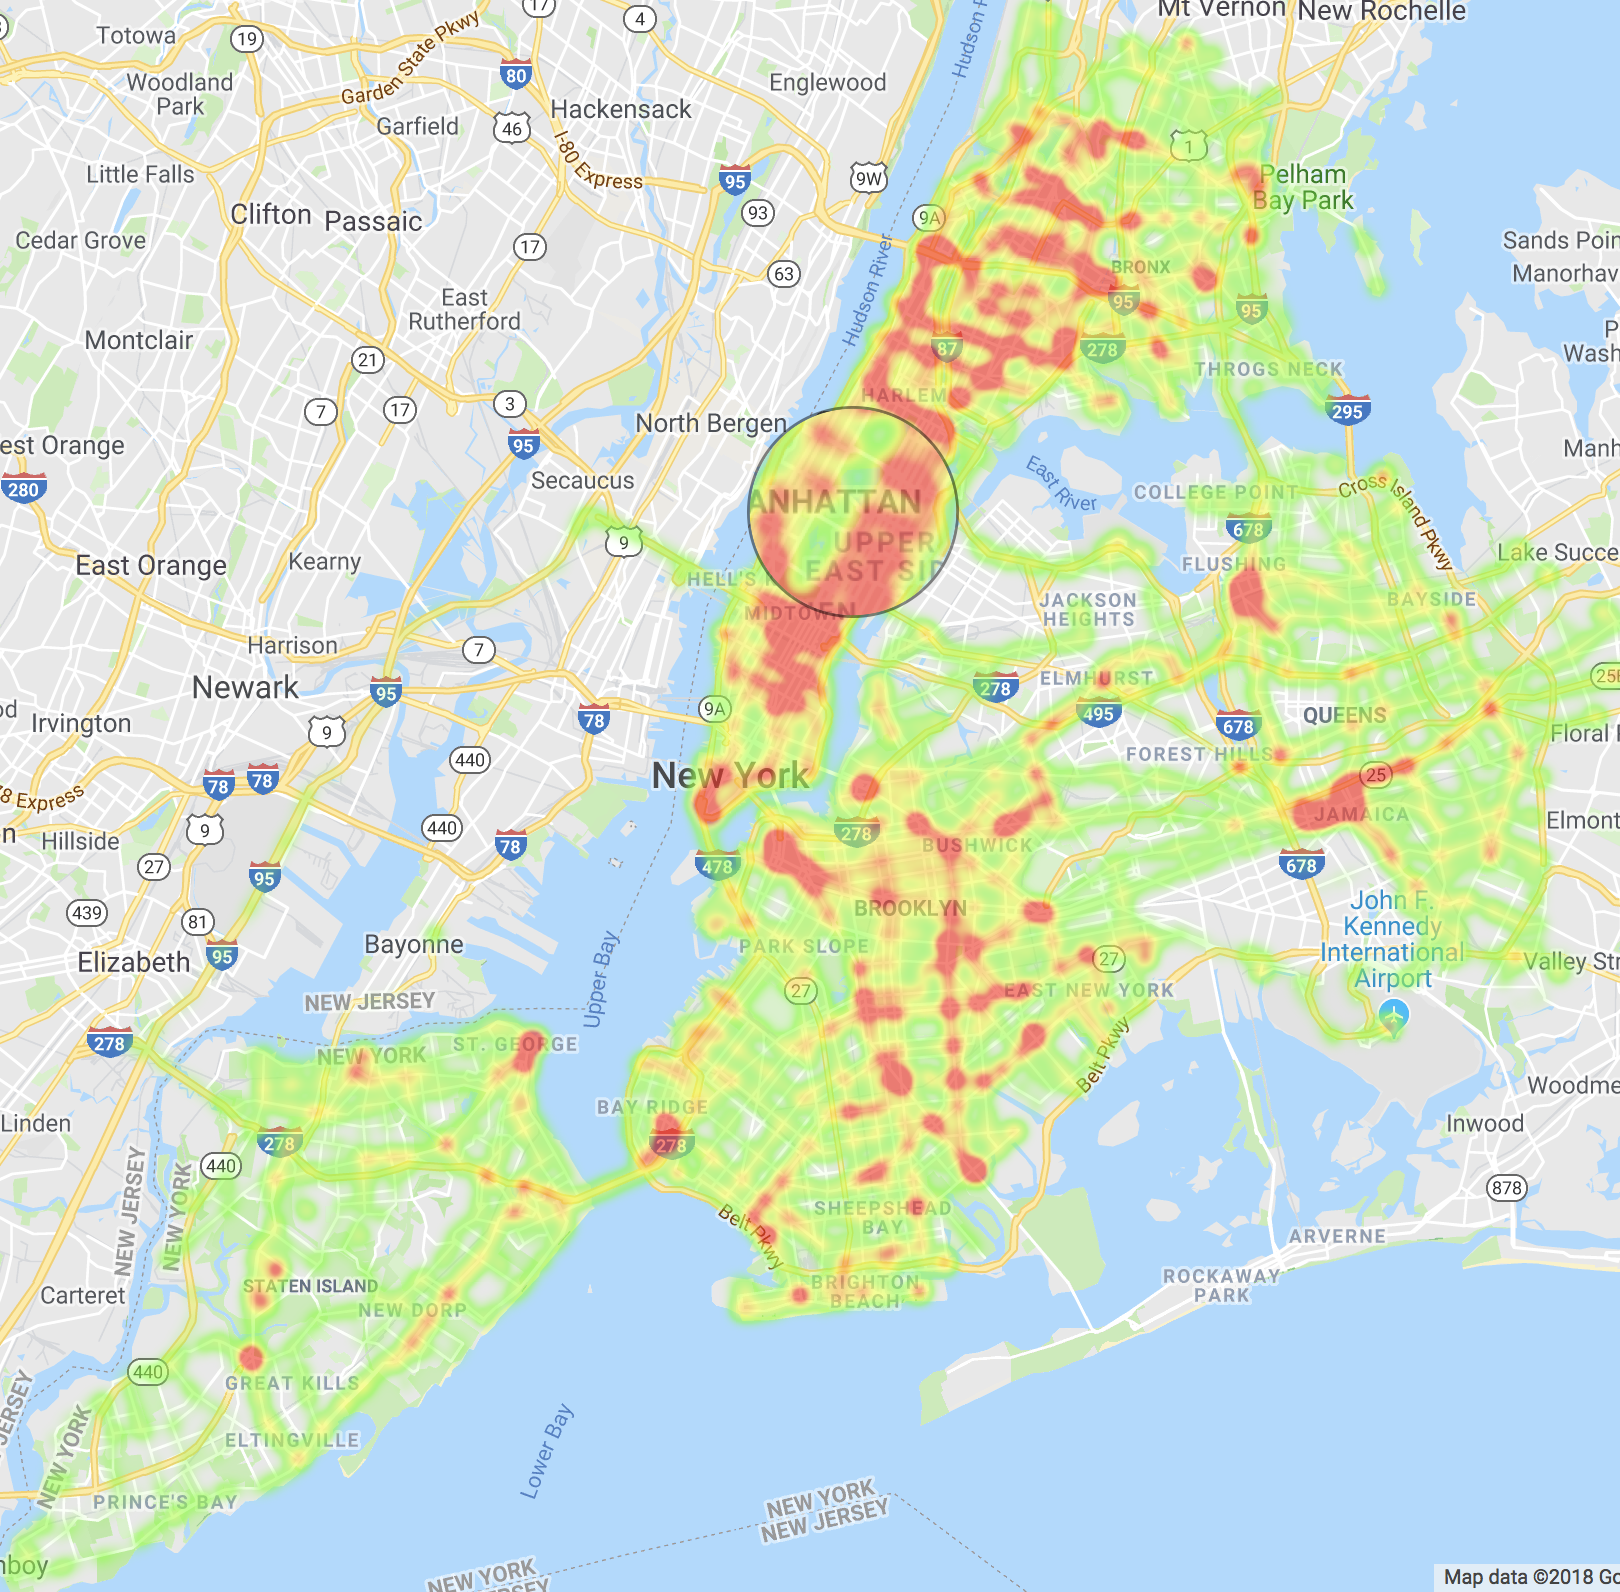

In [517]:
gmap = gmplot.GoogleMapPlotter(40.635170, -73.960803, 10)
gmap.heatmap(latitudes, longitudes)
gmap.draw("bus_heatmap.html")
Image(filename='Bus_location_heatmap.png') 

### 4. Which buses are most delayed?

As a commuter, I want to understand which buses are most delayed and should be avoided on the whole, based on the data for June 2017. It is important to define the criteria for considering buses to be most delayed.

**Criteria:** <br>
1) Duration of Delay: I am going to determine that as a commuter myself, I will not wait for a bus that has known to be more than 10 minutes late on average for the entire month of June. <br>
2) Frequency of Delay: How many times was this bus route or vehicle delayed? <br>

Each row of data represents a vehicle's status at a given point in time ('RecordedAtTime'). 

One vehicle ('VehicleRef' e.g.NYCT_4613) for one bus route (e.g. bus B1) on one journey (e.g. trip from 3am to 4am in 'DirectionRef' 0) can be captured more than once. Hence, observing a delay of 10 minutes twice for one bus route ('PublishedLineName') or one vehicle ('VehicleRef') does not mean that bus route had buses that were repeatitively late. 

Hence, I summarize the data by calculating average delay for each bus for the month of June.

In 'subsetdata' below, each bus route has one line with average delay for the entire month of June. This data contains 236 rows, which corresponds to the number of bus routes for which we have information.

In [554]:
subsetdata = dataset.groupby(['PublishedLineName']).mean()

In [555]:
subsetdata = subsetdata.drop(['DirectionRef', 'VehicleLocation.Latitude','VehicleLocation.Longitude' ,'DistanceFromStop'], axis=1)

This helps us understand which buses were most delayed.

In [558]:
subsetdata[subsetdata['Delay_Minutes']<-10]

,OriginLat,OriginLong,DestinationLat,DestinationLong,Delay_Seconds,Delay_Minutes
PublishedLineName,,,,,,
B25,40.690377,-73.948592,40.688873,-73.943380,-615.141096,-10.250615
M1,40.776991,-73.962578,40.774894,-73.963697,-626.448748,-10.438329
M55,40.727680,-73.998747,40.730656,-73.997188,-606.261390,-10.101277
M60-SBS,40.791508,-73.935226,40.778359,-73.894829,-614.315978,-10.239898
M7,40.775998,-73.968730,40.782823,-73.963709,-665.070732,-11.084550
Q32,40.752412,-73.936172,40.752265,-73.940638,-630.646010,-10.511661
Q56,40.692124,-73.849384,40.693801,-73.843945,-678.705094,-11.312179


On average through the month of June 2017, buses B25, M1, M55, M60-SBS, M7, Q32 and Q56 were delayed more than 10 minutes.

I would not take buses B25, M1, M55, M60-SBS, M7, Q32 and Q56 unless I know that another mode of transportation will also be delayed by more 10 minutes and the duration of travel across both modes is exactly the same.

When it comes to picking a mode of transportation, travel time is another factor to be considered in deciding whether or not to take a bus, which bus to take, whether to take another mode of transportation and so on.

## Conclusion

This notebook has been dedicated to understanding bus delay. 

**Overall Trend:** <br>
The average delay was approximately 6 minutes. The longest bus delay was 301 minutes, which is slightly more than 5 hours. The earliest a bus had arrived was 275 minutes ahead of schedule, which is more than 4.5 hours early.

**Delay by Time of Day for the Month of June 2017:** <br>
Average bus delays were 6 minutes or higher between 09:00 or 9am to 16:00 or 4pm. This pattern of delays aligns with "peak hour" traffic that we see on the road while driving. Given that the values have been averaged over an entire month across all bus routes, it might not strictly align to the "peak hour" traffic pattern observed on one day.

**Most delayed buses:** <br>
Buses B25, M1, M55, M60-SBS, M7, Q32 and Q56 were considered to be the most delayed as the average bus delay was over 10 minutes through month of June.

## Next Steps

Only bus delay was considered in suggesting which buses to avoid. Considering duration of travel and other modes of transporation will give a more complete picture on which buses to avoid. This might require us to find additional data and create attributes that allow us to make comparisons across different modes of transportation.